# Explore h3 resolution on zonal results

The planned process for aggregating spatial data is to first aggregate to an h3 level, and then join those h3 results to the admin level. This notebook will explore the effects of this process on the zonal statistics results but analyzing three raster datasets at 4 h3 resolutions:

## Raster Datasets
| Name | Description | Resolution | Data Type |
| --- | ---| ---| --- |
| GHS-Pop | Gridded population data | 100m | Continuous |
| GHS-SMOD | Gridded urbanization | 1km | Categorical |
| VIIRS NTL | VIIRS nivghttime brightness | ~1km | Continuous |

## H3 levels
| Level | Area (km2) |
| --- | --- |
| 8 | 0.73 |
| 7 | 5.16 |
| 6 | 36.12 |
| 5 | 252.90 | 

In [2]:
import sys, os, importlib, math, multiprocessing
import rasterio, geojson

import pandas as pd
import geopandas as gpd
import numpy as np

from h3 import h3
from tqdm import tqdm
from shapely.geometry import Polygon

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")
import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.ntlMisc as ntl
import GOSTRocks.mapMisc as mapMisc
from GOSTRocks.misc import tPrint

sys.path.append("../src")
import h3_helper
import country_zonal

%load_ext autoreload
%autoreload 2

/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
# Define input datasets
sel_iso3 = "KEN"

admin_bounds = "/home/public/Data/GLOBAL/ADMIN/ADMIN2/HighRes_20230328/shp/WB_GAD_ADM2.shp"
out_folder = f"/home/wb411133/projects/Space2Stats/{sel_iso3}/zonal_comparison"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

global_urban = "/home/public/Data/GLOBAL/GHSL/SMOD/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V1_0.tif"
global_pop_layer = "/home/public/Data/GLOBAL/GHSL/Pop/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif"
ntl_layers = ntl.aws_search_ntl()
ntl_file = ntl_layers[-1]

inA = gpd.read_file(admin_bounds)
selA = inA.loc[inA['ISO_A3'] == sel_iso3].copy()
selA['ID'] = selA.index #Create ID for indexing

raster_defs = [
        #[global_urban, "GHS_SMOD", 'C', [30,23,22,21,13,12,11]], 
        [global_pop_layer, "GHS_POP", 'N'], 
        [ntl_file, 'NTL','N']
    ]

## Run various zonal levels

Run zonal statistics against the h3 grid at various levels (see table above)

In [5]:
final_res = {}
for h3_level in [5,6,7,8]:
    zonalC = country_zonal.country_h3_zonal(sel_iso3, selA, "ID", h3_level, out_folder)
    for cur_raster_def in raster_defs:
        cur_raster = cur_raster_def[0]
        cur_label = cur_raster_def[1]
        tPrint(f'Processing h3 level {h3_level}: {cur_label}')

        if cur_raster_def[2] == 'N':
            zonal_res = zonalC.zonal_raster_urban(cur_raster, global_urban, minVal=0, rastType=cur_raster_def[2])
        else:
            zonal_res = zonalC.zonal_raster_urban(cur_raster, global_urban, minVal=0, 
                                                  rastType=cur_raster_def[2], unqVals=cur_raster_def[3])
        cur_res = country_zonal.connect_polygons_h3_stats(selA, zonal_res, h3_level, "ID", True)
        map_admin = pd.merge(selA, cur_res, left_on="ID", right_on='id')
        final_res[f'{cur_label}_{h3_level}'] = map_admin.copy()

09:33:42	Processing h3 level 5: GHS_POP


100%|██████████| 365/365 [00:01<00:00, 206.71it/s]


(1, 11563, 7953)
09:34:17	Processing h3 level 5: NTL
(1, 2246, 1921)
09:34:37	Processing h3 level 6: GHS_POP


100%|██████████| 365/365 [00:07<00:00, 51.17it/s]


(1, 11563, 7953)
09:36:00	Processing h3 level 6: NTL
(1, 2246, 1921)
09:36:56	Processing h3 level 7: GHS_POP


100%|██████████| 365/365 [00:44<00:00,  8.27it/s] 


(1, 11563, 7953)
09:43:28	Processing h3 level 7: NTL
(1, 2246, 1921)
09:48:33	Processing h3 level 8: GHS_POP


100%|██████████| 365/365 [05:46<00:00,  1.05it/s]  


(1, 11563, 7953)
10:32:28	Processing h3 level 8: NTL
(1, 2246, 1921)


In [17]:
inD = selA.copy()

# run zonal stats directly on the admin boundaries
for cur_raster_def in raster_defs:
    cur_raster = cur_raster_def[0]
    cur_label = cur_raster_def[1]
    tPrint(f'Processing: {cur_label}')

    if cur_raster_def[2] == 'N':
        zonal_res = rMisc.zonalStats(selA, cur_raster, minVal=0, rastType=cur_raster_def[2], reProj=True)
        zonal_res = pd.DataFrame(zonal_res, columns=['SUM', 'MIN', 'MAX', 'MEAN'])    
    else:
        zonal_res = rMisc.zonalStats(selA, cur_raster, minVal=0, rastType=cur_raster_def[2], unqVals=cur_raster_def[3], reProj=True)
    inD[cur_label] = zonal_res['SUM'].values
    
for key, item in final_res.items():
    try:
        inD[key] = item['SUM'].values.astype(float)
    except:
        print(key)
        
inD.head()

11:28:22	Processing: GHS_POP
11:28:29	Processing: NTL


,ISO_A3,ISO_A2,WB_A3,HASC_0,HASC_1,HASC_2,GAUL_0,GAUL_1,GAUL_2,WB_REGION,...,GHS_POP,NTL,GHS_POP_5,NTL_5,GHS_POP_6,NTL_6,GHS_POP_7,NTL_7,GHS_POP_8,NTL_8
36683,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,133402.002027,1782.820068,51796.737927,450.940886,115367.032971,1233.821429,122867.823655,1506.402845,126938.836788,1653.087610
36684,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,195964.470341,1046.790039,161387.554905,936.749120,153378.802814,897.664381,177899.277756,899.498319,191703.671774,1010.824403
36685,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,204961.672418,1124.550049,125153.952002,620.031772,168460.581446,909.788722,192930.049403,1033.911439,199482.151302,1072.926858
36686,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,218527.939659,1886.150146,155845.132956,1295.483997,186836.986520,1650.854277,210673.862441,1816.132172,215838.228994,1853.641294
36687,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,130289.026833,942.410034,NaN,NaN,93953.629052,701.568360,121099.062338,878.275115,126910.909358,920.376328


In [20]:
xx = rasterio.open(cur_raster)

In [23]:
xx.bounds[0:2]

(-180.00208333335, -65.00208445335001)

# Map intersection of admin vectors and hexes

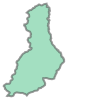

In [4]:
sel_feature = inA['geometry'].iloc[0]
sel_feature